<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/Vega_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4606      0 --:--:-- --:--:-- --:--:--  4606
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 59.0 MB 56 kB/s 
     |████████████████████████████████| 1.0 MB 50.7 MB/s 
+ set +ex
Installation succeeded!


# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [40]:
# Knock in call
# B>K
# Once price reaches B, get immediate payoff (S[knock-in]-K)
# change r to an array of length 'numsteps'

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_out_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)

    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_out_index]/(knock_out_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

numstocks = 3

np.random.seed(np.random.randint(10000))

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
numsteps = 250
numpaths = 100000
drift = jnp.array([0.]*numstocks)
r = jnp.array(np.random.random(numsteps) * 0.1) # r is an array now

cov = jnp.identity(numstocks)*0.5*0.5
initial_stocks = jnp.array([100.]*numstocks) # must be float

T = 1.0
K = 100.0
B = 120.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
#fast_simple(key, initial_stocks, numsteps, drift, cov)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))


# option price
# 3 stocks basket
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)


# delta
# 3 stock basket
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)

9.75914
10 loops, best of 5: 38.6 ms per loop
[0.18455425 0.18532172 0.18505844]
1 loop, best of 5: 907 ms per loop


In [41]:
def VegaFiniteDiff():
  original = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)
  cov_new1 = cov + jnp.array([[0.01**2,0,0],[0,0,0],[0,0,0]])
  cov_new2 = cov + jnp.array([[0,0,0],[0,0.01**2,0],[0,0,0]])
  cov_new3 = cov + jnp.array([[0,0,0],[0,0,0],[0,0,0.01 ** 2]])
  new1 = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov_new1, K, B, T, numpaths)
  new2 = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov_new2, K, B, T, numpaths)
  new3 = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov_new3, K, B, T, numpaths)
  #return new1-original
  return ([(new1-original).tolist()/0.01,(new2-original).tolist()/0.01,(new3-original).tolist()/0.01])

In [42]:
vegas = []

for i in range(1000):
  rng = jax.random.PRNGKey(np.random.randint(10000))
  rng, key = jax.random.split(rng)
  fast_simple = jax.jit(Brownian_motion, static_argnums=2)
  #fast_simple(key, initial_stocks, numsteps, drift, cov)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

  vegas.append(VegaFiniteDiff())

In [43]:
import pandas as pd
vegas_df = pd.DataFrame(vegas)
vegas_mean = vegas_df.mean(axis= 0)
vegas_mean

0    0.056642
1    0.057925
2    0.056415
dtype: float64

In [44]:
vegas_mean.sum()

0.1709832191467285

In [ ]:
prices = []

for i in range(1000):
  rng = jax.random.PRNGKey(np.random.randint(10000))
  rng, key = jax.random.split(rng)
  fast_simple = jax.jit(Brownian_motion, static_argnums=2)
  #fast_simple(key, initial_stocks, numsteps, drift, cov)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

  prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths).tolist())

In [ ]:
prices_array = np.array(prices)
prices_mean = prices_array.mean()
prices_mean

9.771725355148316

In [45]:
0.5 * vegas_mean.sum()  #Half Vega

0.08549160957336426

In [ ]:
upper = prices_mean + 0.5 * vegas_mean.sum()
lower = prices_mean - 0.5 * vegas_mean.sum()

In [ ]:
upper

9.772556782245637

In [ ]:
lower

9.770893928050995

In [ ]:
#import timeit
#x = %timeit -o optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)
#print(x.best)

10 loops, best of 5: 77.5 ms per loop
0.07753229139998438


In [3]:
import time

In [50]:
prices3 = []
stds3 = []
times3 = []
num_steps3 = np.array([300,400])
num_paths = np.array([100,1000,10000,100000])
for j in num_steps3:
  prices_paths = []
  stds_paths = []
  times_paths = []
  for i in num_paths:
    numsteps = j
    numpaths = i
    print(j,i)
    prices_1000 = []
    time_start = time.time()
    for l in range(1000):
      rng = jax.random.PRNGKey(np.random.randint(10000))
      rng, key = jax.random.split(rng)
      fast_simple = jax.jit(Brownian_motion, static_argnums=2)
      #fast_simple(key, initial_stocks, numsteps, drift, cov)
      keys = jax.random.split(key, numpaths)
      batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

      prices_1000.append(optionvalueavg(key, initial_stocks, j, drift, r, cov, K, B, T, i).tolist())
    time_end = time.time()
    time_c= time_end - time_start
    times_paths.append(time_c)
    prices_paths.append(np.array(prices_1000).mean())
    stds_paths.append(np.array(prices_1000).std())
  prices3.append(prices_paths)
  stds3.append(stds_paths)
  times3.append(times_paths)
  #print(i)

300 100
300 1000
300 10000
300 100000
400 100
400 1000
400 10000
400 100000


In [ ]:
prices

[[9.893675017356873,
  9.899760869979858,
  9.901250224113465,
  9.897908854484559,
  9.89839900970459],
 [9.830557419776916,
  9.859220180511475,
  9.854015279769898,
  9.855809280395508,
  9.857455988883972],
 [9.806064664840699,
  9.820311672210693,
  9.811831125259399,
  9.813679944038391,
  9.813540264129639]]

In [ ]:
stds

[[1.117867106342951,
  0.3452628227992561,
  0.11417078701532943,
  0.03619123921467137,
  0.010999211388045958],
 [1.0645118616473486,
  0.3393411811574587,
  0.10984860151507658,
  0.03428070640183699,
  0.010973374778711319],
 [1.0477942316900055,
  0.3287706690307108,
  0.10316100054556254,
  0.03313624201444359,
  0.010197456632044835]]

In [ ]:
times

[[14.016228437423706,
  13.747610569000244,
  14.065049409866333,
  13.95102071762085,
  74.89369821548462],
 [14.80759596824646,
  15.724730253219604,
  16.247059106826782,
  23.379847764968872,
  139.6077287197113],
 [17.46620202064514,
  17.18025493621826,
  17.670422792434692,
  34.769789934158325,
  300.66500520706177]]

In [ ]:
prices2

[[9.809891807556152, 9.787850834846497, 9.774085885047912, 9.77513931465149]]

In [ ]:
stds2

[[1.012307528853526,
  0.3194366355555163,
  0.10368664169053579,
  0.03181539576112715]]

In [ ]:
times2

[[23.009528875350952, 22.58604621887207, 23.02121591567993, 80.90238952636719]]

In [51]:
prices3

[[9.789168832302094, 9.80333538722992, 9.796675113677978, 9.796558026313782],
 [9.782718861103058, 9.80391987323761, 9.800665431976318, 9.79865298652649]]

In [52]:
stds3

[[1.0602742811912182,
  0.3397622800909756,
  0.10940650269667537,
  0.03367589624564316],
 [1.0184738943238016,
  0.33015504841893883,
  0.1090160282571679,
  0.032287803190899196]]

In [53]:
times3

[[19.457382440567017,
  17.473522901535034,
  17.602555513381958,
  49.0515992641449],
 [19.875608205795288,
  19.853262901306152,
  19.924821853637695,
  65.8246419429779]]

In [57]:
import pandas as pd
out = pd.DataFrame()
out['step'] = ['right',50,50,50,50,100,100,100,100,200,200,200,200,300,300,300,300,400,400,400,400,500,500,500,500]
out['path'] = ['right',100, 1000, 10000, 100000,100, 1000, 10000, 100000,100, 1000, 10000, 100000,100, 1000, 10000, 100000,100, 1000, 10000, 100000,100, 1000, 10000, 100000]
out['prices'] = [9.771725355148316, 9.893675017356873,9.899760869979858,9.901250224113465,9.897908854484559,
        9.830557419776916,9.859220180511475,9.854015279769898,9.855809280395508,
        9.806064664840699,9.820311672210693,9.811831125259399,9.813679944038391,
        9.789168832302094, 9.80333538722992, 9.796675113677978, 9.796558026313782,
        9.782718861103058, 9.80391987323761, 9.800665431976318, 9.79865298652649,
        9.809891807556152, 9.787850834846497, 9.774085885047912, 9.77513931465149]
out['std'] = ['0.5 Vega = 0.08549',1.117867106342951,0.3452628227992561,0.11417078701532943,0.03619123921467137,
        1.0645118616473486,0.3393411811574587,0.10984860151507658,0.03428070640183699,
        1.0477942316900055,0.3287706690307108,0.10316100054556254,0.03313624201444359,
        1.0602742811912182,0.3397622800909756,0.10940650269667537,0.03367589624564316,
        1.0184738943238016,0.33015504841893883,0.1090160282571679,0.032287803190899196,
        1.012307528853526,0.3194366355555163,0.10368664169053579,0.03181539576112715]
out['time'] = ['/',14.016228437423706,13.747610569000244,14.065049409866333,13.95102071762085,
         14.80759596824646,15.724730253219604,16.247059106826782,23.379847764968872,
         17.46620202064514,17.18025493621826,17.670422792434692,34.769789934158325,
         19.457382440567017,17.473522901535034,17.602555513381958,49.0515992641449,
         19.875608205795288,19.853262901306152,19.924821853637695,65.8246419429779,
         23.009528875350952, 22.58604621887207, 23.02121591567993, 80.90238952636719]
out

,step,path,prices,std,time
0,right,right,9.771725,0.5 Vega = 0.08549,/
1,50,100,9.893675,1.11787,14.0162
2,50,1000,9.899761,0.345263,13.7476
3,50,10000,9.901250,0.114171,14.065
4,50,100000,9.897909,0.0361912,13.951
5,100,100,9.830557,1.06451,14.8076
6,100,1000,9.859220,0.339341,15.7247
7,100,10000,9.854015,0.109849,16.2471
8,100,100000,9.855809,0.0342807,23.3798
9,200,100,9.806065,1.04779,17.4662


Conclusion:

1000000 path can reach 0.5 vega

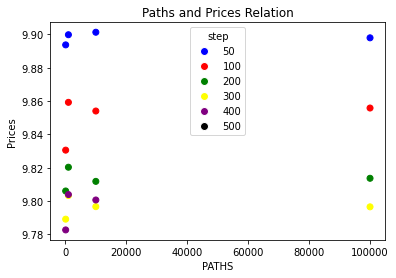

In [62]:
import matplotlib.pyplot as plt

temp = out.iloc[1:20,]
temp = temp[temp['path'] < 1000000]

fig, ax = plt.subplots()

colors = { 50: 'blue', 100: 'red',200:'green',300:'yellow',400:'purple',500:'black' }

ax.scatter(temp['path'], temp['prices'], c=temp['step'].apply(lambda x: colors[x]))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='step', handles=handles,loc = 9)

plt.xlabel('PATHS')
plt.ylabel('Prices')
plt.title('Paths and Prices Relation')
plt.show()

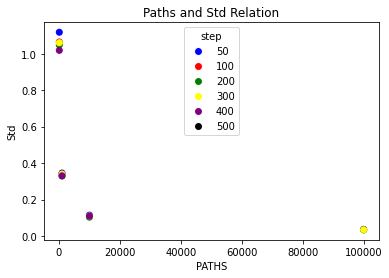

In [63]:
fig, ax = plt.subplots()

colors = { 50: 'blue', 100: 'red',200:'green',300:'yellow',400:'purple',500:'black' }
ax.scatter(temp['path'], temp['std'], c=temp['step'].apply(lambda x: colors[x]))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='step', handles=handles,loc = 9)

plt.xlabel('PATHS')
plt.ylabel('Std')
plt.title('Paths and Std Relation')
plt.show()

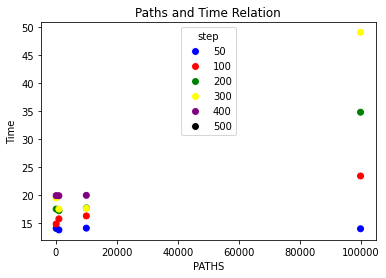

In [64]:
fig, ax = plt.subplots()

colors = { 50: 'blue', 100: 'red',200:'green',300:'yellow',400:'purple',500:'black' }

ax.scatter(temp['path'], temp['time'], c=temp['step'].apply(lambda x: colors[x]))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='step', handles=handles,loc = 9)

plt.xlabel('PATHS')
plt.ylabel('Time')
plt.title('Paths and Time Relation')
plt.show()

In [ ]:
########################################################################################

In [ ]:
Antithetic

In [81]:
def Brownian_motion_anti(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    noise = jnp.hstack((noise, -noise))
    # noise = jnp.hstack((noise, jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,))))
    sigma = jnp.repeat(jnp.diag(cov) ** 0.5,2)
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx = jnp.exp((jnp.repeat(drift,2) - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        # val = jax.ops.index_update(val, jax.ops.index[t], noise[t,:])
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, jnp.hstack((stocks_init, stocks_init)))[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    # print(out)
    # out = jnp.reshape(out, (numpaths, numsteps, numstocks))

    out1 = out[:,:,0:numstocks]
    out2 = out[:,:,numstocks:]

    out = jnp.append(out1, out2, axis = 0)


    knock_out_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_out_index]/(knock_out_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

numstocks = 3

np.random.seed(np.random.randint(10000))

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
numsteps = 500
numpaths = 100000
drift = jnp.array([0.]*numstocks)
r = jnp.array(np.random.random(numsteps) * 0.1) # r is an array now

cov = jnp.identity(numstocks)*0.5*0.5
initial_stocks = jnp.array([100.]*numstocks) # must be float

T = 1.0
K = 100.0
B = 120.0

fast_simple = jax.jit(Brownian_motion_anti, static_argnums=2)
#fast_simple(key, initial_stocks, numsteps, drift, cov)

keys = jax.random.split(key, numpaths/2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))


 
# option price
# 3 stocks basket
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)

9.786108
10 loops, best of 5: 60.9 ms per loop


In [82]:
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths))

9.786108


In [83]:
def VegaFiniteDiff():
  original = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)
  cov_new1 = cov + jnp.array([[0.01**2,0,0],[0,0,0],[0,0,0]])
  cov_new2 = cov + jnp.array([[0,0,0],[0,0.01**2,0],[0,0,0]])
  cov_new3 = cov + jnp.array([[0,0,0],[0,0,0],[0,0,0.01 ** 2]])
  new1 = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov_new1, K, B, T, numpaths)
  new2 = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov_new2, K, B, T, numpaths)
  new3 = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov_new3, K, B, T, numpaths)
  #return new1-original
  return ([(new1-original).tolist()/0.01,(new2-original).tolist()/0.01,(new3-original).tolist()/0.01])

In [78]:
original = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)

In [84]:
vegas_anti = []

for i in range(1000):
  print(i)
  rng = jax.random.PRNGKey(np.random.randint(10000))
  rng, key = jax.random.split(rng)
  fast_simple = jax.jit(Brownian_motion_anti, static_argnums=2)
  #fast_simple(key, initial_stocks, numsteps, drift, cov)
  keys = jax.random.split(key, numpaths)
  batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

  vegas_anti.append(VegaFiniteDiff())

0


ValueError: ignored